In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pickle
from tqdm import tqdm

import numpy as np
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
# import darkhistory
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
sys.path.append(os.environ['DH_DIR'])
# import DM21cm
sys.path.append('..')

## 1. DM density box

In [3]:
import darkhistory.physics as phys

In [4]:
rs = 30
rho_DM = phys.rho_DM * rs**3 # [eV/cm^3]
print(rho_DM, 'eV/cm^3')

34140204.0 eV/cm^3


In [5]:
from PIL import Image, ImageOps # just for fun, you don't need this

src = 255 - np.array(ImageOps.grayscale(Image.open('plots/source.png').resize((100,100))), dtype=np.float32)
src /= np.mean(src)
src = np.einsum('i,jk->ijk', np.ones((100,)), src)

In [6]:
rho_DM_box = rho_DM * src

## 2. Calculate energy injection

In [7]:
print(phys.inj_rate('swave', rs, mDM=2e6, sigmav=2e-26), 'eV/cm^3/s')

1.1655535291616161e-17 eV/cm^3/s


In [8]:
print(phys.inj_rate('decay', rs, mDM=2e6, lifetime=3e25), 'eV/cm^3/s')

1.1380068e-18 eV/cm^3/s


In [9]:
def inj_rate_box(inj_type, rho_DM_box, mDM=None, sigmav=None, lifetime=None):
    """ Dark matter annihilation/decay energy injection rate box.
    (See darkhistory.physics.inj_rate for original.)

    Parameters
    ----------
    inj_type : {'swave', 'decay'}
        Type of injection.
    rho_DM_box : ndarray (3D)
        DM density box at redshift.
    mDM : float, optional
        DM mass in eV.
    sigmav : float, optional
        Annihilation cross section in cm\ :sup:`-3`\ s\ :sup:`-1`\ .
    lifetime : float, optional
        Decay lifetime in s.

    Returns
    -------
    ndarray
        The dE/dV_dt injection rate box in eV cm\ :sup:`-3`\ s\ :sup:`-1`\ .

    """
    if inj_type == 'swave':
        return rho_DM_box**2 * sigmav / mDM
    elif inj_type == 'decay':
        return rho_DM_box / lifetime
    else:
        raise ValueError('Unknown inj_type.')

In [10]:
z = inj_rate_box('swave', rho_DM_box, mDM=2e6, sigmav=2e-26)

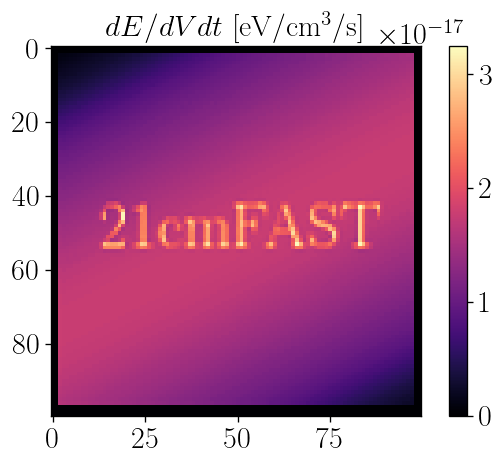

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(z[0], cmap='magma')
ax.set(title=r'$dE/dVdt$ [eV/cm$^3$/s]')
fig.colorbar(im, ax=ax);

## 3. Ionization box

In [12]:
src = np.array(ImageOps.grayscale(Image.open('plots/source2.png')), dtype=np.float32)
src /= 255.
ionization_box = np.einsum('i,jk->ijk', np.ones((100,)), src) # dimension is [1]

## 4. Energy $f$ going into various channels

In [13]:
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools

from dm21cm.common import abscs_nBs_test
abscs = abscs_nBs_test

from dm21cm.interpolators import BatchInterpolator

In [14]:
DATA_DIR = os.environ['DM21CM_DATA_DIR'] + '/transferfunctions/nBs_test'
dep_interp = BatchInterpolator(DATA_DIR + '/phot_cdep_dlnz48m_renxo_ad.p')

In [18]:
# prepare inputs
nBs_box = jnp.clip(jnp.array(rho_DM_box/rho_DM), 0, 2.7)
nBs_in = nBs_box.flatten()
x_box = jnp.array(ionization_box)
x_in = x_box.flatten()

spec = spectools.rebin_N_arr(np.array([1]), np.array([1200]), out_eng=abscs['photE'])
spec_E = jnp.array(spec.N * spec.eng)
spec_E /= jnp.sum(spec_E)

In [19]:
f_boxs = dep_interp(rs, spec.N, nBs_in, x_in).reshape(100, 100, 100, 5) / spec.toteng()

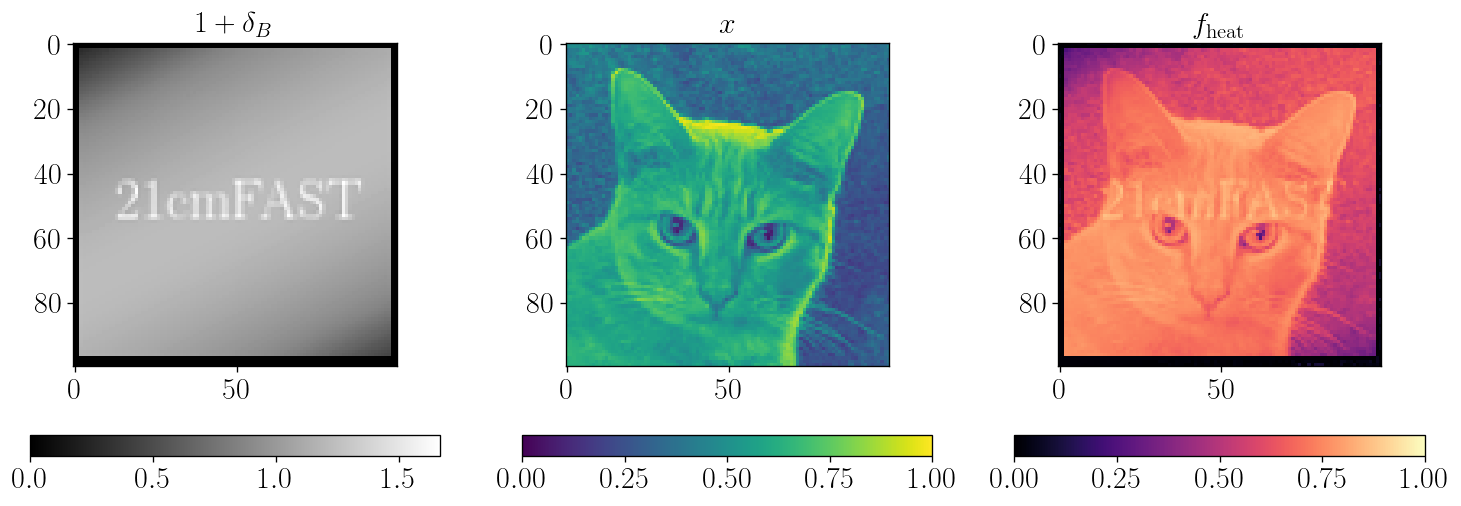

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
im0 = axs[0].imshow(nBs_box[0], cmap='binary_r')
im1 = axs[1].imshow(x_box[0], vmax=1, vmin=0)
im2 = axs[2].imshow(f_boxs[0,:,:,3], cmap='magma', vmax=1, vmin=0)
fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')
fig.colorbar(im2, ax=axs[2], orientation='horizontal')
axs[0].set(title=r'$1+\delta_B$')
axs[1].set(title=r'$x$')
axs[2].set(title=r'$f_\mathrm{heat}$')
plt.savefig('plots/example_injection.png')

## A. Generate DM source image

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
xs = np.linspace(0, 1, 100)
xs, ys = np.meshgrid(xs, xs)
ax.imshow(np.sin(xs+2*ys+np.pi), vmin=-1.2)
ax.text(10, 55, '21cmFAST', fontsize=50)
ax.set_aspect(1)
ax.axis('off')
plt.savefig('plots/source.png', dpi=25)